In [2]:
select_features=False

In [3]:
run load-clean-select.ipynb

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Morphology was measured for 1063.0 cells.

The numbers of cells and nuclei correspond to each other.

The are no duplicated column names: True
The are no duplicated column names: True
Cytoplasm measurements were taken for 1063 cells.

The are no duplicated column names: True
Reading the dataset with E-cadherin...
E-cadherin was measured for 576 cells.

The are no duplicated column names: True
Reading the dataset with Vimentin and Cytokeratins...
Vimentin and Cytokeratins were measured for 487 cells.

The are no duplicated column names: True

Full dataset has shape: (1063, 562)
Initial shape is: (1063, 562)
Features with zero variance:
 Index(['centerZ_cell', 'eulernumber_cell', 'children_cytoplasm_count_cell',
       'loc_centermassintensityZ_wga', 'loc_centerZ_cell',
       'loc_maxintensityZ_wga', 'centerZ_nucl', 'eulernumber_nucl',
       'children_cells_count', 'children_cytoplasm_count_nucl',
       'loc_centermassintensityZ_dapi', 'loc_centerZ_nucl',
       'loc_maxintensityZ_dap

# Which dataset?

In [4]:
# The full dataset
# df = measurements
# Dataset without clusters at 64kPa
df = measurements_red
# Dataset without 0.5kPa, 8kPa and clusters at 64kPa
# df = measurements_5
# Dataset without 0.5kPa, 8kPa and clusters at 64kPa with balanced classes
# df = measurements_b
df.shape

(826, 502)

## New images

In [ ]:
to_exclude = [
    '16.0-C-B5-1', 
              '16.0-C-B5-2', 
#               '16.0-C-B5-3', 
              '16.0-C-B5-4', 
              '16.0-C-B5-6', 
              '16.0-C-B5-7'
             ]

for image in to_exclude:
    df.drop(df[df.image == image].index, inplace=True)

df.reset_index(drop=True, inplace=True)

In [ ]:
cols = morph_cols

print(df[cols].shape)

X = df[cols]

n_clusters = 2

func.hc(df, cols, n_clusters, save=False)

In [ ]:
# df.cluster = df.cluster + 1

plt.rcParams['figure.figsize'] = (2, 2)
row_colors, palette = func.create_palette(df, by='cluster')

sns.countplot(x="cluster", data=df, palette=palette);

In [ ]:
counts = df.groupby('stiffness').cluster.value_counts().unstack()
cluster_cols = ['cluster'+ str(n+1) for n in range(n_clusters)]
counts.columns = cluster_cols
counts['total'] = df.groupby('stiffness').size()
for col in cluster_cols:
    counts[col] = counts[col] / counts.total * 100
counts.iloc[:, 0 : n_clusters].plot(kind='bar', width=0.7, 
                                    stacked=True, 
                                    color=palette.values(), 
                                    figsize=(5, 5));

In [ ]:
pc_model, pc_cols, pc_df = func.pca(df, cols)

for cluster in range(0, n_clusters):
    m = find_medoid(pc_df[pc_df.cluster == cluster], pc_cols, cluster)

## Scale and save

In [ ]:
# Features to use
cols = geom_cols
# Feature map
X = df[cols]

# Standartise the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pd.DataFrame(data = X_scaled, columns = geom_cols).to_csv("../datasets/BandC_morphology.csv")

## Separate dataframes for combinations

In [ ]:
dfB = df[df.combination == "B"].reset_index(drop=True)
dfC = df[df.combination == "C"].reset_index(drop=True)
print(dfB.shape, dfC.shape)

# PCA on geometric features

In [ ]:
pca_model, pc_cols, pc_df = func.pca(df, geom_cols)

In [ ]:
plt.rc("figure", figsize=(8, 8))

# row_colors, palette = create_palette(df, by='stiffness')
row_colors, palette = func.create_palette(df, by='comb')

# sns.scatterplot(x='pc_1', y='pc_2', data=pc_df, 
#                 hue='stiffness', palette=palette);
sns.scatterplot(x='pc_1', y='pc_2', data=pc_df, hue='combination', palette=palette);

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

plt.rc("figure", figsize=(10, 10))

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(pc_df.pc_1, pc_df.pc_2, pc_df.pc_3, s=10, c='orangered');

ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.set_zticklabels([]);

ax.set_xlabel('PC1, 15%');
ax.set_ylabel('PC2, 10%');
ax.set_zlabel('PC3, 6%');

ax.set_xlim([-12, 15]);
ax.set_ylim([-12, 15]);
ax.set_zlim([-10, 10]);

centroids = pc_df.groupby('stiffness')[['pc_1', 'pc_2', 'pc_3']].mean().reset_index()

ax.scatter(centroids.pc_1, centroids.pc_2, centroids.pc_3, 
           s=500, alpha=1, 
           marker='X', edgecolor='black',
           c=sns.color_palette("Set3", 5));

# plt.savefig('../results/PCA 3D centroids.png', bbox_inches='tight', dpi=300);

In [ ]:
plt.rc("figure", figsize=(7, 1.5))
sns.distplot(pc_df.pc_1, color='orangered', bins=50);
# plt.axis("off");
plt.xlim([-12, 15]);
plt.savefig('../results/PCA histogram1.png', bbox_inches='tight', dpi=300);

In [ ]:
sns.distplot(pc_df.pc_2, color='orangered', bins=50);
# plt.axis("off");
plt.xlim([-12, 15]);
plt.savefig('../results/PCA histogram2.png', bbox_inches='tight', dpi=300);

In [ ]:
sns.distplot(pc_df.pc_3, color='orangered', bins=50);
# plt.axis("off");
plt.xlim([-10, 10]);
plt.savefig('../results/PCA histogram3.png', bbox_inches='tight', dpi=300);

# Distances between stiffness groups

In [ ]:
from sklearn.metrics import pairwise_distances

stiffness = df.stiffness.unique()
mean_dist = np.zeros([len(stiffness), len(stiffness)], dtype=np.float32)
i = 0

for s1 in stiffness:
    j = 0
    for s2 in stiffness:
        dist = pairwise_distances(df.loc[df.stiffness == s1, geom_cols], df.loc[df.stiffness == s2, geom_cols])
        mean_dist[i, j] = dist.sum() / (dist.shape[0] * dist.shape[1])
        j += 1
    i += 1
    
plt.rc("figure", figsize=(5, 5))
sns.heatmap(pd.DataFrame(mean_dist, columns=stiffness, index=stiffness),
            cmap=sns.color_palette("Blues", 100));

# Hierarchical clustering

In [ ]:
neighb_cols = [col for col in geom_cols if "neighbors" in col]

In [ ]:
shape_cols = [col for col in geom_cols if col not in neighb_cols]

In [5]:
# Features to use
cols = geom_cols

print(df[cols].shape)

X = df[cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

(826, 150)


In [ ]:
row_colors, palette = func.create_palette(df)

sns.clustermap(pd.DataFrame(X_scaled, columns=cols), 
               metric='euclidean', method='ward',
               col_cluster=False,
               cmap=sns.color_palette('RdBu_r', 100), robust=True, 
               row_colors=row_colors);

plt.savefig('../results/Clustering.png', bbox_inches='tight', dpi=300);

# Define subpopulations

## How many subpopulations?

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

plt.rcParams['figure.figsize'] = (5, 5)

cluster_range = [2, 3, 4, 5, 6]

for n_clusters in cluster_range:
    fig, ax = plt.subplots(1);
    ax.set_xlim([-0.2, 0.4])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    agg = AgglomerativeClustering(n_clusters=n_clusters)
    agg.fit(X_scaled) 
    cluster_labels = agg.labels_
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])
    ax.set_xticks([-0.2, -0.1, 0, 0.2, 0.4])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

In [ ]:
def plot_score(score, title, save=False):
    tmp = pd.DataFrame(score).T
    tmp_cols = ['run'+ str(n+1) for n in range(score.shape[0])]
    tmp.columns = tmp_cols
    tmp['n_clusters'] = tmp.index + 2
    tmp = pd.melt(tmp, id_vars=['n_clusters'], value_vars=tmp_cols)

    plt.rcParams['figure.figsize'] = (5, 3)
    sns.lineplot(x=tmp.n_clusters, y=tmp.value,
                             ci=95, linewidth=3, color='orangered');
    plt.xlabel("Number of clusters");
    plt.ylabel("Value");
    plt.title(title);
    if save:
        plt.savefig('../results/' + title + '.png', bbox_inches='tight', dpi=300);

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from s_dbw import SD

def get_subset(X):
    n_cells = X.shape[0]
    indices = np.random.permutation(range(0, n_cells))[ :np.int(0.3 * n_cells)]
    subset = X[indices, :]
    return subset

repeats = 30
max_clusters = 10
cluster_range = range(2, max_clusters)

silhouette = np.zeros([repeats, len(cluster_range)])
db_score = np.zeros([repeats, len(cluster_range)])

for i in range(repeats):
#     X_train, _, _, _ = train_test_split(X, y, test_size=0.5)
    subset = get_subset(X_scaled)
    j = 0
    for n_clusters in cluster_range:
        agg = AgglomerativeClustering(n_clusters=n_clusters)
        agg.fit(subset)
        silhouette[i, j] = silhouette_score(subset, agg.labels_, metric='euclidean')
        db_score[i, j] = davies_bouldin_score(subset, agg.labels_)
        j += 1

In [ ]:
plot_score(silhouette, "Silhouette score", save=False)

In [ ]:
plot_score(db_score, "Davies-Bouldin index", save=False)

In [ ]:
plt.rcParams['figure.figsize'] = (5, 3)

# 1 is the best, 0 indicates overlapping clusters
for i in range(db_score.shape[0]):
    sns.lineplot(cluster_range, silhouette[i, :],             
                 color='skyblue', linewidth=1);
sns.lineplot(cluster_range, silhouette.mean(axis = 0), 
             color='orangered', linewidth=3);
plt.title("Silhouette score");
plt.xlabel("Number of clusters")
# plt.savefig('../results/Silhouette.png', bbox_inches='tight', dpi=300);

plt.figure();
# Zero is better
for i in range(db_score.shape[0]):
    sns.lineplot(cluster_range, db_score[i, :],             
                 color='skyblue', linewidth=1);
sns.lineplot(cluster_range, db_score.mean(axis=0),             
                 color='orangered', linewidth=3);
plt.title("Davies-Bouldin index");
plt.xlabel("Number of clusters");
# plt.savefig('../results/Davies-Bouldin.png', bbox_inches='tight', dpi=300);

## Run HC

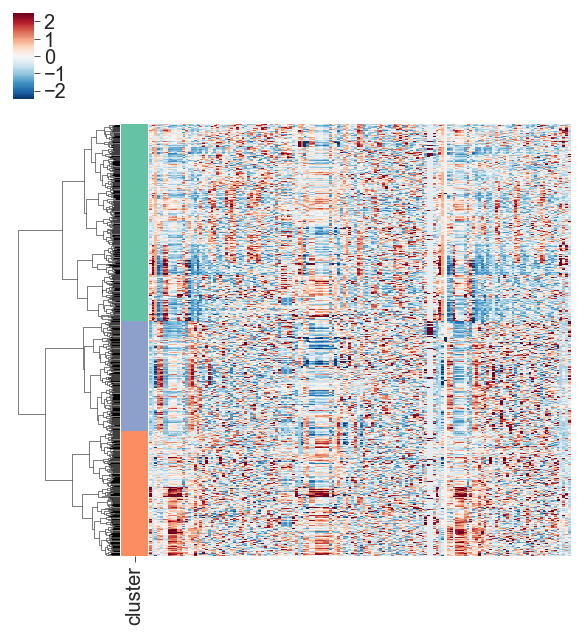

In [6]:
# cols = geom_cols
n_clusters = 3

func.hc(df, cols, n_clusters, save=False)

In [ ]:
func.hc(dfB, geom_cols, n_clusters=3, save=False)

In [ ]:
func.hc(dfC, geom_cols, n_clusters=3, save=False)

** Reassign labels **

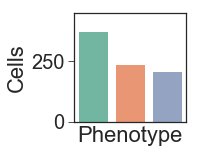

In [7]:
# Number of observations in each cluster
plt.rcParams['figure.figsize'] = (2, 2)
row_colors, palette = func.create_palette(df, by='cluster')

sns.countplot(x="cluster", data=df, palette=palette);
plt.xlabel("Phenotype");
plt.xticks([]);
plt.ylabel("Cells");
plt.ylim([0, 450]);
# plt.title("Cells in each cluster");
# plt.savefig('../results/Clusters count.png', bbox_inches='tight', dpi=300);

In [ ]:
df.groupby('cluster').size()

In [ ]:
dfB.groupby('cluster').size()

In [ ]:
dfC.groupby('cluster').size()

## Distribution of clusters

### Simple proportion:
** Proportion of cells of each cluster to total cell number per stiffness**

In [8]:
counts = df.groupby('stiffness').cluster.value_counts().unstack()
cluster_cols = ['cluster'+ str(n+1) for n in range(n_clusters)]
counts.columns = cluster_cols
counts['total'] = df.groupby('stiffness').size()
for col in cluster_cols:
    counts[col] = counts[col] / counts.total * 100
counts

,cluster1,cluster2,cluster3,total
stiffness,,,,
0.2,48.026316,23.684211,28.289474,152
2.0,33.613445,21.008403,45.378151,238
16.0,54.228856,31.840796,13.930348,201
32.0,52.380952,40.476190,7.142857,126
64.0,44.954128,33.944954,21.100917,109


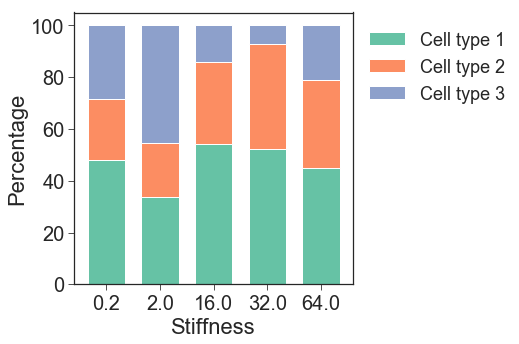

In [9]:
counts.iloc[:, 0 : n_clusters].plot(kind='bar', width=0.7, 
                                    stacked=True, 
                                    color=palette.values(), 
                                    figsize=(5, 5));

plt.xticks(rotation='horizontal')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8), 
           fontsize=18, 
           labels= ['Cell type ' + str(i+1) for i in range(n_clusters)]);
plt.xlabel("Stiffness");
plt.ylabel("Percentage");
# plt.title("Proportion of cells of each type");
plt.savefig('../results/Cluster proportions.png', bbox_inches='tight', dpi=300);

### Add confidence intervals for proportions
** For two clusters only**

In [10]:
if n_clusters > 2:
    print("Error, check maths!")
else:
    counts['err'] = 1.96 * np.sqrt(counts.cluster1 * counts.cluster1 / counts.total)

Error, check maths!


In [11]:
counts['err1'] = 1.96 * np.sqrt(counts.cluster1 * (100 - counts.cluster1) / counts.total)
counts['err2'] = 1.96 * np.sqrt(counts.cluster2 * (100 - counts.cluster2) / counts.total)
counts['err3'] = 1.96 * np.sqrt(counts.cluster3 * (100 - counts.cluster3) / counts.total)

In [ ]:
counts[['cluster1', 'cluster2', 'cluster3']].plot(kind='bar', width=0.8, 
                                                  yerr=[counts.err1, counts.err2, counts.err3],
                                                  capsize=4,
                                                  color=palette.values(),
                                                  figsize=(5, 4));

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, 
           labels=['Cell type ' + str(i) for i in range(n_clusters)]);
plt.xticks(rotation='horizontal')
plt.xlabel("Stiffness, kPa");
plt.ylabel("Proportion");
plt.ylim([0, 100]);
# plt.title("Proportion of cells of each type across stiffness values");
# plt.savefig('../results/Clusters geom_cols.png', bbox_inches='tight', dpi=300);

### Distribution of clusters across images and stiffness values

In [12]:
counts = df.groupby(['stiffness', 'image']).cluster.value_counts().unstack().fillna(0)
cluster_cols = ['cluster'+ str(n+1) for n in range(n_clusters)]
counts.columns = cluster_cols
counts['total'] = df.groupby(['stiffness', 'image']).size()
for col in cluster_cols:
    counts[col] = counts[col] / counts.total * 100
counts.head()

cluster1   cluster2  cluster3  total
stiffness image                                            
0.2       0.2-B-A1-1  40.000000  40.000000      20.0      5
          0.2-B-A1-2  71.428571  28.571429       0.0      7
          0.2-B-A1-3  20.000000  20.000000      60.0     10
          0.2-B-A1-4  87.500000   0.000000      12.5      8
          0.2-B-A1-5  50.000000   0.000000      50.0      6

In [13]:
counts.reset_index(inplace=True)
counts = pd.melt(counts, id_vars=['stiffness'], value_vars=cluster_cols)
counts.head()

,stiffness,variable,value
0,0.2,cluster1,40.000000
1,0.2,cluster1,71.428571
2,0.2,cluster1,20.000000
3,0.2,cluster1,87.500000
4,0.2,cluster1,50.000000


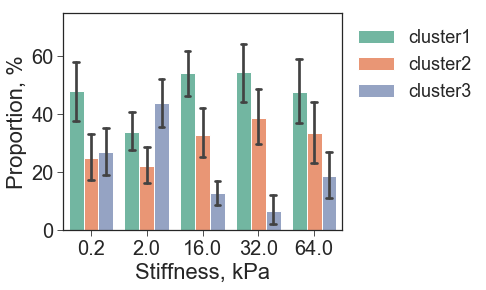

In [15]:
plt.rcParams['figure.figsize'] = (5, 4)

row_colors, palette = func.create_palette(df, by='cluster')

sns.barplot(x='stiffness', y='value', 
            hue='variable', data=counts,
            ci=95, capsize=.1, 
            palette=palette.values());
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=18);
plt.xlabel("Stiffness, kPa");
plt.ylabel("Proportion, %");
plt.ylim([0, 75]);
# plt.title("Distribution of cell types across stiffness values");
plt.savefig('../results/Clusters proportions + error bars.png', bbox_inches='tight', dpi=300);

# Visualise clusters

## Find medoids

In [ ]:
def find_medoid(df, cols, cluster):
    distances = pairwise_distances(df[cols])
    medoid = df.reset_index().iloc[distances.sum(axis=0).argmin()]
    print("\nThe medoid of cluster {} is the cell with label {}.".format(cluster, medoid.label))
    return medoid

In [ ]:
df_scaled = pd.concat([df.loc[:, ['label', 'stiffness', 'cluster']], 
                       pd.DataFrame(data = X_scaled, columns = cols)], axis=1)

for cluster in range(1, n_clusters + 1):
    find_medoid(df_scaled[df_scaled.cluster == cluster], geom_cols, cluster)

In [ ]:
pc_model, pc_cols, pc_df = func.pca(df, cols)

for cluster in range(1, n_clusters + 1):
    m = find_medoid(pc_df[pc_df.cluster == cluster], pc_cols, cluster)

## PCA + medoids

In [ ]:
row_colors, palette = func.create_palette(df, by='cluster')
plt.rcParams['figure.figsize'] = (5, 5)

pc_model, pc_cols, pc_df = func.pca(df, cols)

sns.scatterplot(x='pc_1', y='pc_2', data=pc_df, hue='cluster', palette=palette);
plt.xlabel("PC1")
plt.ylabel("PC2")

for cluster in range(1, n_clusters + 1):
    medoid = find_medoid(pc_df[pc_df.cluster == cluster], pc_cols, cluster)
    
    plt.scatter(medoid.pc_1, medoid.pc_2, s=200, marker='X', edgecolor='white', c='k');
    
# plt.legend(fontsize=18);
plt.savefig('../results/Clusters PCA.png', bbox_inches='tight', dpi=300);

## Manifold embedding

In [ ]:
def plot_embedding(X_emb):
    cols = [('x_' + str(i)) for i in range(1, X_emb.shape[1] + 1)]
    df_emb = pd.concat([df[['label', 'stiffness', 'cluster']], 
                        pd.DataFrame(data = X_emb, columns = cols)], axis=1)

    plt.rcParams['figure.figsize'] = (5, 5)
    row_colors, palette = func.create_palette(df_emb, by='cluster')

    sns.scatterplot( x="x_1", y="x_2", data=df_emb, hue='cluster', 
                    palette=palette, legend='full');
    
    return df_emb

### t-SNE

In [ ]:
scaler = StandardScaler()
X_scaled_ = scaler.fit_transform(X[important_features.feature])

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=200)

X_emb = tsne.fit_transform(X_scaled)

df_emb = plot_embedding(X_emb)

## U-Map

In [ ]:
from umap import UMAP
umap = UMAP()

X_emb = umap.fit_transform(X_scaled)

df_emb = plot_embedding(X_emb)

In [ ]:
def tune_umap(X, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    umap = UMAP(n_neighbors=n_neighbors,
                min_dist=min_dist,
                n_components=n_components,
                metric=metric, 
                random_state=1)
    X_emb = umap.fit_transform(X);
    return X_emb

In [ ]:
for n in (5, 10, 15, 20, 50, 100, 200):
    X_emb = tune_umap(X_scaled, n_neighbors=n, title='n_neighbors = {}'.format(n))
    plt.figure();
    plot_embedding(X_emb)

In [ ]:
for d in (0.0, 0.1, 0.15, 0.2, 0.25, 0.5, 0.99):
    X_emb = tune_umap(X_scaled, min_dist=d, title='min_dist = {}'.format(d))
    plt.figure();
    plot_embedding(X_emb)

# Determine most important features

** Hyperparameter tuning **

In [ ]:
rf_clf = RandomForestClassifier()
best_rf_clf = rf.random_search_param(rf_clf, X_train, y_train)

In [ ]:
rf.test_rf_model(best_rf_clf, 0, X_train, X_test, y_train, y_test)
print("\nTop 10 important features:\n")
important_features = rf.get_important_features(best_rf_clf, X.columns)

** Save the best estimator **

In [ ]:
joblib.dump(best_rf_clf, 'models/best_rf_clf.pkl')

** Load the best estimator **

In [7]:
rf_clf = joblib.load('models/highacc_rf_clf.pkl')

In [33]:
X = df[cols]
y = df.cluster

# selected_features = 'measurements_5_over90_morph.txt'
selected_features = 'measurements_5_over80_morph.txt'
X = proc.select_features(X, filename=selected_features, cols='geom')
 
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# rf_clf = RandomForestClassifier(n_estimators=100)
# rf_clf.fit(X_train, y_train)

# ### Save the current model
# joblib.dump(rf_clf, 'models/latest_rf_clf.pkl')

Training set size: (743, 100)
Test set size: (83, 100)


** Evaluate the model **


Number of observations of each class in the training set:
 1    336
2    216
3    191
Name: cluster, dtype: int64

Number of observations of each class in the test set:
 1    41
2    22
3    20
Name: cluster, dtype: int64

Null accuraccy: 0.4939759036144578
Testing accuraccy: 0.9879518072289156
Testing f-score: 0.9841179807146908
    2   1   3
2  21   0   1
1   0  41   0
3   0   0  20

Top 10 important features:

Important features
                   feature    weight
2       eccentricity_cell  0.095316
1        compactness_cell  0.078621
7          perimeter_cell  0.058749
3         formfactor_cell  0.047560
0               area_cell  0.039094
4      maximumradius_cell  0.037581
82       zernike_4_0_cyto  0.034885
5   minferetdiameter_cell  0.028337
42       compactness_nucl  0.022817
43      eccentricity_nucl  0.022663


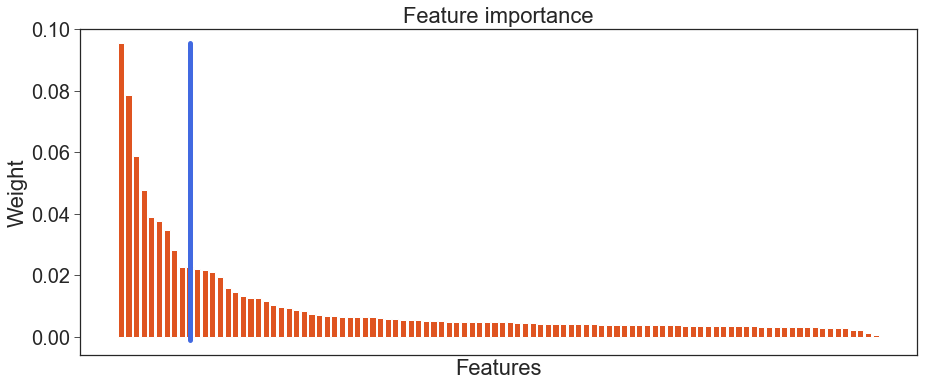

In [34]:
rf.test_rf_model(rf_clf, 0, X_train, X_test, y_train, y_test)
print("\nTop 10 important features:\n")
important_features = rf.get_important_features(rf_clf, X.columns)

** Make predictions for clumped cells**

In [10]:
X_ = clumped[cols]

selected_features = 'measurements_5_over80_morph.txt'
X_ = proc.select_features(X_, filename=selected_features, cols='geom')

clumped['cluster'] = rf_clf.predict(X_)

In [11]:
cluster_type = CategoricalDtype(categories=list(range(1, n_clusters+1)), ordered=True)
clumped.cluster = clumped.cluster.astype(cluster_type)

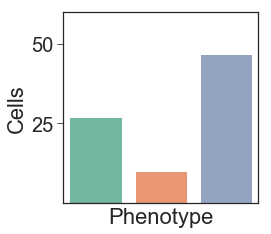

In [12]:
# Clusters among clumped cells
plt.rcParams['figure.figsize'] = (3.5, 3.5)
row_colors, palette = func.create_palette(df, by='cluster')

sns.countplot(clumped.cluster, palette=palette);
plt.xlabel("Phenotype");
plt.xticks([]);
plt.ylabel("Cells");
plt.ylim([0, 60]);
plt.yticks([25, 50]);
# plt.title("Clumped cells");
plt.savefig('../results/Clumped count.png', bbox_inches='tight', dpi=300);

In [13]:
p_corr = clumped[geom_cols].corrwith(clumped.cluster, method='spearman')
fts = p_corr.abs().sort_values(ascending=False).head(13)
fts

compactness_cell         0.800956
zernike_0_0_cell         0.797174
eccentricity_cell        0.783540
majoraxislength_cell     0.759027
majoraxislength_cyto     0.749516
maxferetdiameter_cell    0.744823
eccentricity_cyto        0.736257
formfactor_cell          0.709660
extent_cell              0.690433
perimeter_cell           0.674873
zernike_0_0_cyto         0.663949
perimeter_cyto           0.649369
zernike_2_0_cell         0.616826
dtype: float64

Welch's unequal variances t-test on samples 1 vs 2.  	 p-value = 0.28.
Welch's unequal variances t-test on samples 2 vs 3.  	 p-value = 0.45.


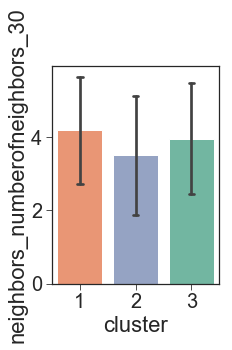

In [14]:
plt.rcParams['figure.figsize'] = (3, 4)
row_colors, palette = func.create_palette(clumped, by='cluster')

col = 'neighbors_numberofneighbors_30'
ax = sns.barplot(x='cluster', y=col, data=clumped,
                 ci='sd', capsize=.1, palette=palette);

x_start, x_end, signif = func.ttest(clumped, 'cluster', col, equal_var=False, verbose=True)
func.stat_annot(clumped, 'cluster', col, x_start, x_end, signif, [0, 100], kind='barplot')

# ax.set_xticklabels(['Single', 'Clumped']);
# plt.xlabel("");
# plt.ylabel("Ratio");
# plt.title("CVR");
# plt.savefig('../results/Clumped CVR barplot.png', bbox_inches='tight', dpi=300);

In [ ]:
p_corr = clumped[biom_cols].corrwith(clumped.cluster, method='spearman')
fts = p_corr.abs().sort_values(ascending=False).head(13)
fts

In [ ]:
clumped.cluster.unique().sort_values()

** Correlation between important features**

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)

sns.heatmap(df[important_features.feature].corr(), 
            annot=True,
            annot_kws={"size": 16},
            vmin=-1, vmax=1,
            xticklabels=False,
            yticklabels=False,
            cmap=sns.color_palette("RdBu_r", 20));
# plt.savefig('../results/for thesis.png', bbox_inches='tight', dpi=300);

## Boxplots of most important features

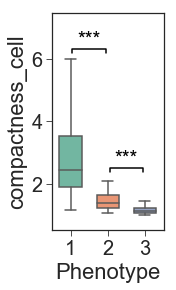

In [15]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = func.create_palette(df, by='cluster')
col = important_features.iloc[1,0]

sns.boxplot(x='cluster', y=col, data=df,
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0.5, 7.5], kind='boxplot')

plt.xlabel("Phenotype");
plt.ylabel("Compactness, a.u.");
plt.savefig('../results/compactness per cluster.png', bbox_inches='tight', dpi=300);

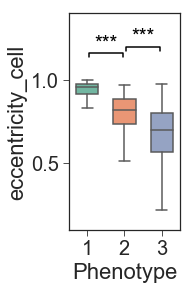

In [16]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = func.create_palette(df, by='cluster')
col = important_features.iloc[0,0]

sns.boxplot(x='cluster', y=col, data=df,
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0.1, 1.4], kind='boxplot')

plt.xlabel("Phenotype");
plt.ylabel("Eccentricity, a.u.");
plt.savefig('../results/eccentricity per cluster.png', bbox_inches='tight', dpi=300);

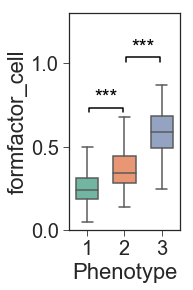

In [17]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = func.create_palette(df, by='cluster')
col = important_features.iloc[3,0]

sns.boxplot(x=df.cluster, y=df[col],
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0, 1.3], kind='boxplot')

plt.xlabel("Phenotype");
plt.ylabel("Circularity, a.u.");
plt.savefig('../results/circularity per cluster.png', bbox_inches='tight', dpi=300);

In [18]:
def px_to_um(x):
    return x * 0.2076

In [19]:
df.perimeter_cell = px_to_um(df.perimeter_cell)

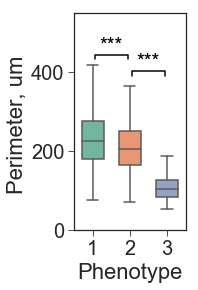

In [20]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = func.create_palette(df, by='cluster')
col = important_features.iloc[2,0]

sns.boxplot(x=df.cluster, y=df[col],
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0, 550], kind='boxplot')

plt.xlabel("Phenotype");
plt.ylabel("Perimeter, um ");
plt.savefig('../results/perimeter per cluster.png', bbox_inches='tight', dpi=300);

In [21]:
df.area_cell = px_to_um(px_to_um(df.area_cell))

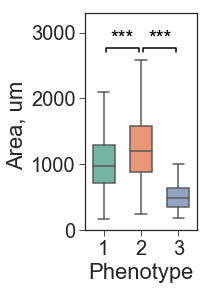

In [22]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = func.create_palette(df, by='cluster')
col = important_features.iloc[4,0]

sns.boxplot(x=df.cluster, y=df[col],
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0, 3300], kind='boxplot')

plt.xlabel("Phenotype");
plt.ylabel("Area, um ");
plt.savefig('../results/area per cluster.png', bbox_inches='tight', dpi=300);

## Cells that are further apart

In [ ]:
from sklearn.metrics import pairwise_distances

dist = pairwise_distances(X_scaled)

indices = np.unravel_index(np.argmax(dist, axis=None), dist.shape)

In [ ]:
plt.imshow(dist, zorder=2, cmap='Blues', interpolation='nearest');

In [ ]:
df.loc[indices[0], 'label'], df.loc[indices[1], 'label']

## PCA stiffness against cluster

In [ ]:
plt.rc("figure", figsize=(8, 8))

centroids = pc_df.groupby('stiffness')[['pc_1', 'pc_2']].mean().reset_index()

row_colors, palette = create_palette(df, by='stiffness')
sns.scatterplot(x='pc_1', y='pc_2', data=pc_df, 
                style='cluster', markers=['o', 's'],
                hue='stiffness', palette=palette);

sns.scatterplot(x="pc_1", y="pc_2", data=centroids, 
                hue='stiffness', palette=palette, 
                s=200, marker='X', edgecolor='black', 
                legend=None);

## PCA on important features

In [ ]:
pc_model, pc_cols, pc_df = func.pca(df, important_features.feature)

plt.rc("figure", figsize=(6, 6))
sns.scatterplot(x='pc_1', y='pc_2', data=pc_df, hue='cluster', palette=palette);

plt.figure();
sns.scatterplot(x='pc_2', y='pc_3', data=pc_df, hue='cluster', palette=palette);

plt.figure();
sns.scatterplot(x='pc_1', y='pc_3', data=pc_df, hue='cluster', palette=palette);

In [ ]:
s_corr = df[neighb_cols].corrwith(df.cluster, method='spearman')

print(s_corr.abs().sort_values(ascending=False).head(10))

plt.rcParams['figure.figsize'] = (15, 2)

sns.heatmap(pd.DataFrame(s_corr, columns=['Pearsons']).T, 
            cmap=sns.color_palette("RdBu_r", 100), 
            vmin=-1, vmax=1);

In [ ]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = func.create_palette(df, by='cluster')
col = "neighbors_percenttouching_3"

sns.boxplot(x=df.cluster, y=df[col],
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=True)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [-1, 50], kind='boxplot')

plt.xlabel("Phenotype");

# Relationship to biomarkers

## Correlations with biom features

integratedintensityedge_ecad    0.373404
integratedintensity_ecad        0.356611
maxintdisplacement_ker          0.356201
massdisplacement_ecad           0.348643
massdisplacement_ker            0.334696
massdisplacement_vim            0.312080
maxintdisplacement_vim          0.304859
minintensityedge_ker            0.298581
minintensity_ecad               0.285022
minintensity_ker                0.284719
dtype: float64


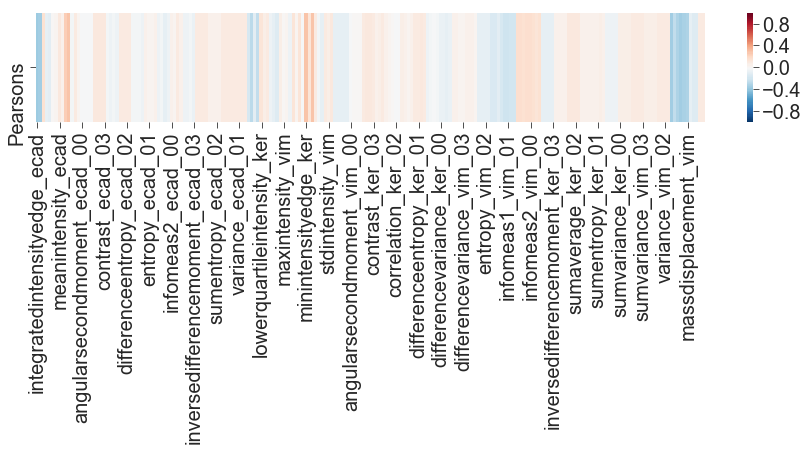

In [23]:
s_corr = df[biom_cols].corrwith(df.cluster, method='spearman')

print(s_corr.abs().sort_values(ascending=False).head(10))

plt.rcParams['figure.figsize'] = (15, 2)

sns.heatmap(pd.DataFrame(s_corr, columns=['Pearsons']).T, 
            cmap=sns.color_palette("RdBu_r", 100), 
            vmin=-1, vmax=1);

## Expression in clusters

**E-cadherin**

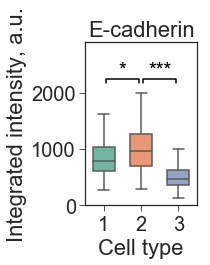

In [24]:
row_colors, palette = func.create_palette(df, by='cluster')
plt.rcParams['figure.figsize'] = (2, 3)

col = 'integratedintensity_ecad'

sns.boxplot(x='cluster', y=col, data=df[(df.stiffness != "16.0") | (df.well != "B6")],
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df[(df.stiffness != "16.0") | (df.well != "B6")], 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df[(df.stiffness != "16.0") | (df.well != "B6")], 'cluster', col, x_start, x_end, signif, [0, 2900], kind='boxplot')

plt.title("E-cadherin")
plt.xlabel("Cell type");
plt.ylabel("Integrated intensity, a.u.");
# plt.savefig('../results/Ecad II per cluster.png', bbox_inches='tight', dpi=300);

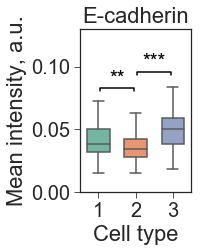

In [25]:
row_colors, palette = func.create_palette(df, by='cluster')
plt.rcParams['figure.figsize'] = (2, 3)

col = 'meanintensity_ecad'

sns.boxplot(x='cluster', y=col, data=df[(df.stiffness != "16.0") | (df.well != "B6")],
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df[(df.stiffness != "16.0") | (df.well != "B6")], 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df[(df.stiffness != "16.0") | (df.well != "B6")], 'cluster', col, x_start, x_end, signif, [0, 0.13], kind='boxplot')

plt.title("E-cadherin")
plt.xlabel("Cell type");
plt.ylabel("Mean intensity, a.u.");
# plt.savefig('../results/Ecad MI per cluster.png', bbox_inches='tight', dpi=300);

** Vimentin**

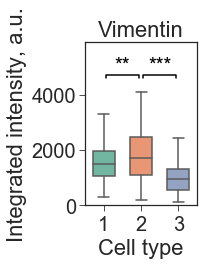

In [26]:
row_colors, palette = func.create_palette(df, by='cluster')
plt.rcParams['figure.figsize'] = (2, 3)

col = 'integratedintensity_vim'

sns.boxplot(x='cluster', y=col, data=df,
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0, 5900], kind='boxplot')

plt.title("Vimentin")
plt.xlabel("Cell type");
plt.ylabel("Integrated intensity, a.u.");
plt.savefig('../results/Vim II per cluster.png', bbox_inches='tight', dpi=300);

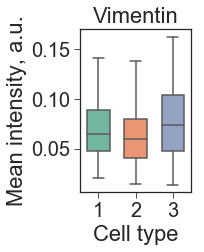

In [27]:
row_colors, palette = func.create_palette(df, by='cluster')
plt.rcParams['figure.figsize'] = (2, 3)

col = 'meanintensity_vim'

sns.boxplot(x='cluster', y=col, data=df,
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0, 0.26], kind='boxplot')

plt.title("Vimentin")
plt.xlabel("Cell type");
plt.ylabel("Mean intensity, a.u.");
plt.savefig('../results/Vim MI per cluster.png', bbox_inches='tight', dpi=300);

** Cytokeratins**

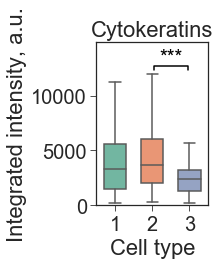

In [28]:
row_colors, palette = func.create_palette(df, by='cluster')
plt.rcParams['figure.figsize'] = (2, 3)

col = 'integratedintensity_ker'

sns.boxplot(x='cluster', y=col, data=df,
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0, 14900], kind='boxplot')

plt.title("Cytokeratins")
plt.xlabel("Cell type");
plt.ylabel("Integrated intensity, a.u.");
plt.savefig('../results/Ker II per cluster.png', bbox_inches='tight', dpi=300);

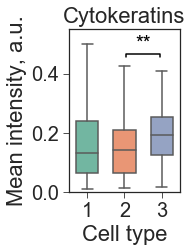

In [29]:
row_colors, palette = func.create_palette(df, by='cluster')
plt.rcParams['figure.figsize'] = (2, 3)

col = 'meanintensity_ker'

sns.boxplot(x='cluster', y=col, data=df,
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0, 0.55], kind='boxplot')

plt.title("Cytokeratins")
plt.xlabel("Cell type");
plt.ylabel("Mean intensity, a.u.");
plt.savefig('../results/Ker MI per cluster.png', bbox_inches='tight', dpi=300);

** CVR**

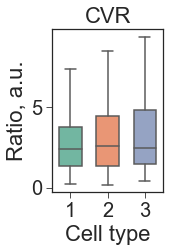

In [30]:
row_colors, palette = func.create_palette(df, by='cluster')
plt.rcParams['figure.figsize'] = (2, 3)

col = 'cvratio'

sns.boxplot(x='cluster', y=col, data=df,
            width=0.6, palette=palette, showfliers=False);

x_start, x_end, signif = func.ttest(df, 'cluster', col, equal_var=False, verbose=False)
func.stat_annot(df, 'cluster', col, x_start, x_end, signif, [0, 10], kind='boxplot')

plt.title("CVR")
plt.xlabel("Cell type");
plt.ylabel("Ratio, a.u.");
plt.savefig('../results/CVR per cluster.png', bbox_inches='tight', dpi=300);

### Mass displacement

** Show on a single plot**

In [ ]:
tmp = pd.melt(df[['stiffness', 'cluster', 'massdisplacement_ker', 'massdisplacement_ecad']],
              id_vars=['stiffness', 'cluster'],
              value_vars=['massdisplacement_ker', 'massdisplacement_ecad'], 
              var_name='biom', value_name='massdisp')

In [ ]:
plt.rcParams['figure.figsize'] = (5, 4)

row_colors, palette = create_palette(tmp, 'biom')

sns.boxplot(x=tmp.cluster, y=px_to_um(tmp.massdisp), 
            hue=tmp.biom, palette=palette,
            width=0.6, showfliers=False);

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18);
plt.ylim([0, 17]);
plt.xlabel("Cell type");
plt.ylabel("Displacement, um");
plt.title("")
plt.savefig('../results/massdisp per cluster.png', bbox_inches='tight', dpi=300);

** Separate plots and statistical testing**

In [ ]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = create_palette(df, by='cluster')

sns.boxplot(x=df.cluster, y=df.meanintensity_wga / df.area_cell, 
            width=0.6, palette=palette, showfliers=False);

# plt.ylim([0, 13]);
plt.xlabel("Cell type");
plt.ylabel("Mass displacement, um");
plt.title("Cytokeratins")
# plt.savefig('../results/massdisp ker per cluster.png', bbox_inches='tight', dpi=300);

In [ ]:
stat_tests('massdisplacement_ker')

In [ ]:
plt.rcParams['figure.figsize'] = (2, 4)
sns.boxplot(x=df.cluster, y=px_to_um(df.massdisplacement_vim), 
            width=0.6, palette=palette, showfliers=False);

plt.ylim([0, 17]);
plt.xlabel("Cell type");
plt.ylabel("Mass displacement, um");
plt.title("Vimentin");
plt.savefig('../results/massdisp vim per cluster.png', bbox_inches='tight', dpi=300);

In [ ]:
stat_tests('massdisplacement_vim')

## CTCF of ker and vim

In [ ]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = create_palette(df, by='cluster')

sns.boxplot(x=df.cluster, y=df.ctcf_ker, 
            width=0.6, palette=palette, showfliers=False);
# plt.figure()
# sns.barplot(x=df.cluster, y=df.ctcf_ker, 
#             ci=95, capsize=.1, palette=palette);

# plt.ylim([0, 13]);
plt.xlabel("Cell type");
plt.ylabel("CTCF, um");
plt.title("Cytokeratins");
plt.savefig('../results/ker per cluster.png', bbox_inches='tight', dpi=300);

In [ ]:
stat_tests('ctcf_ker')

In [ ]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = create_palette(df, by='cluster')

sns.boxplot(x=df.cluster, y=df.ctcf_vim, 
            width=0.6, palette=palette, showfliers=False);
# plt.figure()
# sns.barplot(x=df.cluster, y=df.ctcf_vim, 
#             ci=95, capsize=.1, palette=palette);

# plt.ylim([0, 13]);
plt.xlabel("Cell type");
plt.ylabel("CTCF, um");
plt.title("Vimentin");
plt.savefig('../results/vim per cluster.png', bbox_inches='tight', dpi=300);

In [ ]:
stat_tests('ctcf_vim')

## CV ratio

In [ ]:
plt.rcParams['figure.figsize'] = (2, 4)

row_colors, palette = create_palette(df, by='cluster')

sns.boxplot(x=df.cluster, y=df.cvratio, 
            width=0.6, palette=palette, showfliers=False);
# plt.figure()
# sns.barplot(x=df.cluster, y=df.cvratio, 
#             ci=95, capsize=.1, palette=palette);

# plt.ylim([0, 13]);
plt.xlabel("Cell type");
plt.ylabel("Ratio, a.u.");
plt.title("Cytokeratins to Vimentin ratio");
plt.savefig('../results/CVR per cluster.png', bbox_inches='tight', dpi=300);

In [ ]:
stat_tests('cvratio')

## Regions of biomarker levels

In [ ]:
df['region'] = "00"
df.loc[(df.ctcf_ker < df.ctcf_ker.median()) & (df.ctcf_vim > df.ctcf_vim.median()), 'region'] = "01"
df.loc[(df.ctcf_ker > df.ctcf_ker.median()) & (df.ctcf_vim < df.ctcf_vim.median()), 'region'] = "10"
df.loc[(df.ctcf_ker > df.ctcf_ker.median()) & (df.ctcf_vim > df.ctcf_vim.median()), 'region'] = "11"

In [ ]:
# Number of observations in each region
sns.countplot(x="region", data=df);
plt.xlabel("Region");
plt.ylabel("Count");
plt.title("Number of cells in each region");

In [ ]:
plt.rcParams['figure.figsize'] = (12, 12)

sns.scatterplot(x='ctcf_ker', y='ctcf_vim', data=df,
                hue='stiffness', style='region', s=100,
                palette=sns.color_palette("Set3", 5));

In [ ]:
df.groupby(['stiffness', 'region']).size()

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)

tmp = df.groupby(['stiffness', 'region']).size().unstack()

tmp['total'] = df.groupby('stiffness').size()

tmp['00'] = tmp['00'] / tmp.total * 100
tmp['01'] = tmp['01'] / tmp.total * 100
tmp['10'] = tmp['10'] / tmp.total * 100
tmp['11'] = tmp['11'] / tmp.total * 100

tmp.iloc[:, 0 : 4].plot(kind='bar', width=0.7, stacked=True, color=sns.color_palette("Set2", 4));


plt.xticks(rotation='horizontal')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, 
           labels=('Low cytokeratins, low vimentin', 
                   'Low cytokeratins, high vimentin', 
                   'High cytokeratins, low vimentin', 
                   'High cytokeratins, high vimentin'));
plt.xlabel("Stiffness, kPa");
plt.ylabel("Proportion");
# plt.title("Proportion of cells of each type across stiffness values");

In [ ]:
df.groupby(['stiffness', 'cluster']).ctcf_ker.mean()

In [ ]:
df.groupby(['stiffness', 'cluster']).ctcf_vim.median()

In [ ]:
plt.rcParams['figure.figsize'] = (6, 4)
sns.barplot(x='stiffness', y='ctcf_ker', 
            hue='cluster', data=df,
            ci='sd', capsize=.1,
#             showfliers=False,
            palette=palette.values());

In [ ]:
sns.barplot(x='stiffness', y='ctcf_vim', 
            hue='cluster', data=df,
            ci=95, capsize=.1,
#             showfliers=False,
            palette=palette.values());

In [ ]:
sns.boxplot(x=df.stiffness, y=df.massdisplacement_vim, width = 0.6, showfliers=False);